# Introduction
PyMCEF construct the efficient frontier from given jointly simulated asset returns. 
With risk meausre absolute semideviation and fixed target under-performance, the optimizatoin can be reformulated as an Linear Programming problem. 
With one single optimization, PyMCEF can find all optimal solutions with risk tolerance $\lambda\in [0,\infty)$, and each optimal solution cooresponds with an interval of $\lambda$.
The correctness of each optimal portfolio and its corresponding interval of $\lambda$ can be checked against existing Linear Programming softwares.

The accuracy and speed of PyMCEF is benchmarked against [CyLP](https://github.com/coin-or/CyLP), a Python interface for [CLP](https://projects.coin-or.org/Clp). 
We choose to benchmark against CLP because of its superior performance compared with other open source LP solvers (GLPK etc.)
The [performance](http://plato.asu.edu/ftp/lpsimp.html) of CLP is close to commerical LP softwares. 

### Linear Programming Setup 

Let's denote the random returns of all $N$ assets as a vector Y.
A portfolio is defined by the $N$-vector of weights $\{w_n\}_{n=1}^N$.
The reward of a portfolio is defined as its expected return.

$$E[Y^{T}w]=E[\sum_{n=1}^{N}w_{n}Y_{n}]$$

Consider $K$ samples of $Y$: $\{Y^{k}\}_{k=1}^{K}$ and their sample
means:
\begin{eqnarray*}
\overline{Y}_{n} & = & \frac{1}{K}\sum_{k=1}^{K}Y_{n}^{k},\\
\overline{Y} & = & \left[\overline{Y}_{1},\dots,\overline{Y}_{n}\right]^{T}.
\end{eqnarray*}

Wtih absolute semideviation as risk measure, the optmization becomes the following:

\begin{eqnarray}
\underset{{u_{k},w_{n},v_{k}}}{\mathrm{argmin}} & \frac{1}{K}\sum_{k=1}^{K}u_{k}-\lambda\sum_{n=1}^{N}w_{n}\overline{Y}_{n}\\
\mathrm{subject\ to} & \sum_{n=1}^{N}w_{n} & =1\\
& u_{k}+\sum_{n=1}^{N}w_{n}(Y_{n}^{k}-\overline{Y}_{n})-v_{k} & =0\quad \forall k=1,\dots,K \\
 & w_{n},u_{k},v_{k} & \ge0.
\end{eqnarray}

With fixed target under-performance as risk measure, 
the optimization becomes the following:

\begin{eqnarray}
\underset{{u_{k},w_{n},v_{k}}}{\mathrm{argmin}} & \frac{1}{K}\sum_{k=1}^{K}u_{k}-\lambda\sum_{n=1}^{N}w_{n}\overline{Y}_{n}\\
\mathrm{subject\ to} & \sum_{n=1}^{N}w_{n} & =1\\
 & u_{k}+\sum_{n=1}^{N}w_{n}Y_{n}^{k}-v_{k} & =t\quad \forall k=1,\dots,K \\
 & w_{n},u_{k},v_{k} & \ge0,
\end{eqnarray}
where $t$ is the target, and $u_k$ are auxilary variables and $v_k$ are slack variables. 

# Benchmark Problems

We start with a small starter problem where the details of LP problem and the optimal solutions can be displayed. 
After that, we test with larger problem to compare the speed of PyMCEF and CyLP.

### Starter problem

Consider an investment universe with 3 assets, whose cross sectional returns have 3 equally possible outcomes:

|           | Asset 1 | Asset 2 | Asset 3 |
|-----------|---------|---------|---------|
| Outcome 1 | 10      | 1       | 5       |
| Outcome 2 | -2      | 0       | 2      |
| Outcome 3 | -3      | 1       | -3      |
We use the fixed-target under-performance as risk measure and choose the fixed-target as $t=0$.
In this case, the linear programming problem is:

\begin{align*}
\underset{\mathrm{u_{1},u_{2},u_{3},w_{1},w_{2},w_{3},v_{1},v_{2},v_{3}\ge0}}{\mathrm{argmin}} & \frac{1}{3}u_{1}+\frac{1}{3}u_{2}+\frac{1}{3}u_{3}-\lambda\left(\frac{5}{3}w_{1}+\frac{2}{3}w_{2}+\frac{1}{3}w_{3}\right)\\
\left[\begin{array}{ccccccccc}
0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0\\
1 &  &  & 10 & 1 & 5 & -1\\
 & 1 &  & -2 & 0 & 2 &  & -1\\
 &  & 1 & -3 & 1 & -3 &  &  & -1
\end{array}\right] & \left[\begin{array}{c}
u_{1}\\
u_{2}\\
u_{3}\\
w_{1}\\
w_{2}\\
w_{3}\\
v_{1}\\
v_{2}\\
v_{3}
\end{array}\right]=\left[\begin{array}{c}
1\\
0\\
0\\
0
\end{array}\right]
\end{align*}

With PyMCEF we can obtain all the optimal solutions, with $\lambda$ varying from $+\infty$ to $0$.

In [1]:
%%capture
from pymcef import SimpleEF, RiskMeasure
import numpy as np
# notice that each row corresponds of all realizations of one asset return

returns = np.array([10,-2,-3,1,0,1,5,2,-3]).reshape((3, 3))
labels = ['Asset 1', 'Asset 2', 'Asset 3']
sol = SimpleEF(training_set = returns, \
               risk_measure = RiskMeasure.FixTargetUnderPerformance, 
               target_return = 0,\
               asset_names = labels)

The solutions are:

In [2]:
i = 1
for prt in sol.frontier_in_sample:
    print("Efficient portfolio: " + str(i))
    lbd_l, lbd_u = prt['lambda_l'], prt['lambda_u']
    print("  Risk tolerance interval: (" + str(lbd_l) + ", " + str(lbd_u) + ")")
    ws = prt['weight']
    ks = [labels[i] for i in ws.keys()]
    vs = [str(v) for v in  ws.values()]
    print("  Positions: ")
    print("    " + ", ".join(ks))
    print("    " + ", ".join(vs))
    i += 1
#sol.frontier_in_sample[0]

Efficient portfolio: 1
  Risk tolerance interval: (4.0, inf)
  Positions: 
    Asset 1
    1.0
Efficient portfolio: 1
  Risk tolerance interval: (1.6, 4.0)
  Positions: 
    Asset 1, Asset 3
    0.5, 0.5
Efficient portfolio: 3
  Risk tolerance interval: (0.0, 1.6)
  Positions: 
    Asset 1, Asset 2, Asset 3
    0.125, 0.75, 0.125


Now we choose various risk tolerances and use CyLP to obtain the optimal solutions. 
Each solution obtained by CyLP should agree with one of the three solutions produced by PyMCEF, whose interval of $\lambda$ covers that particular risk tolerance used by CyLP.

CyLP allow the user to specify inequity constraints, let's reformulate the LP problem with that:

\begin{eqnarray*}
\min_{u_{k},w_{n},v_{k}} & \frac{1}{K}\sum_{k=1}^{K}u_{k}-\lambda\sum_{n=1}^{N}w_{n}\overline{Y}_{n}\\
\mathrm{subject\ to} & \sum_{n=1}^{N}w_{n} & =1\\
 & u_{k}+\sum_{n=1}^{N}w_{n}Y_{n}^{k} & \ge t\\
 & w_{n},u_{k} & \ge0.
\end{eqnarray*}

As can be shown from the results displayed below, CyLP validates PyMCEF on this starter problem.
Notice that without PyMCEF, you have no knowledge of those intervals, all you can do is to try your luck with many different values of $\lambda$, 
and hope that the solutions you obtain will cover the part of efficient frontier that you are interested.

In [3]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML, display
import tabulate
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray
lambdas = np.linspace(5.0, 0.0, 21)

s = CyClpSimplex()

# Add variables
w = s.addVariable('w', 3)
u = s.addVariable('u', 3)
A = np.matrix([[10, 1, 5],[-2, 0, 2],[-3, 1, -3]], dtype='float64')
B = np.matrix(np.eye(3, dtype='float64'))
b = CyLPArray([0.0, 0.0, 0.0])

# Add constraints
s += B * u + A * w >= b
s += w.sum() == 1.0
s += w >= 0.0
s += u >= 0.0

# Set the objective function
c = CyLPArray([5.0/3.0, 2.0/3.0, 4.0/3.0])
c2 = CyLPArray([1.0/3.0, 1.0/3.0, 1.0/3.0])
output = [['Risk tolerance'] + labels]
for lbd in lambdas:
    c1 = lbd * c
    s.objective = c2 * u -  c1 * w
    s.primal()
    sol_w = s.primalVariableSolution['w'] 
    output.append([lbd] + sol_w.tolist())
display(HTML(tabulate.tabulate(output, tablefmt='html')))

Risk tolerance,Asset 1,Asset 2,Asset 3
5.0,1.0,0.0,0.0
4.75,1.0,0.0,0.0
4.5,1.0,0.0,0.0
4.25,1.0,0.0,0.0
4.0,1.0,0.0,0.0
3.75,0.5,0.0,0.5
3.5,0.5,0.0,0.5
3.25,0.5,0.0,0.5
3.0,0.5,0.0,0.5
2.75,0.5,0.0,0.5


### Heavy-duty problem

Now let's use Monte Carlo to simulate a return distribution with a large number of realizations.
We will validate the results obtained by PyMCEF by CyLP and compare their speed.

We use a 3D normal distribution with the following covariance matrix and mean.


\begin{align*}
\mu=\left[\begin{array}{c}
5\\
2\\
4
\end{array}\right], & \Sigma=\left[\begin{array}{ccc}
10 & -3 & -1\\
-3 & 2 & 1\\
-1 & 1 & 4
\end{array}\right].
\end{align*}

The fixed target is chosen as $t=1$ in the risk measure.

In [4]:
from numpy.random import multivariate_normal as mn
from time import time
numSims = 5000
t = 1
means = [5, 2, 4]
covs = [[10, -3, -1],
        [-3, 2, 1], 
        [-1, 1, 4]] 
returns = mn(means, covs, numSims)

tic = time()
simple_ef = SimpleEF(target_return=t, training_set=returns.T,
                     risk_measure=RiskMeasure.FixTargetUnderPerformance)
cost_pymcef = time() - tic 
print("Total time cost for PyMCEF: " + str(cost_pymcef) + " s")
ports = simple_ef.frontier_in_sample
weights_pymcef = np.zeros((len(ports), 3))
lbds = []
for i in range(len(ports)):
    ws = ports[i]['weight']
    lbd_l = ports[i]['lambda_l']
    lbd_u = ports[i]['lambda_u']
    lbds.append((lbd_l + lbd_u)/2.0 if i > 0 else 2.0*lbd_l)
    for k, v in ws.items():
        weights_pymcef[i][k] = v

Total time cost for PyMCEF: 0.0660901069641 s


In [5]:
smplx = CyClpSimplex()

# Add variables
w = smplx.addVariable('w', 3)
u = smplx.addVariable('u', numSims)
A = np.matrix(returns)
B = np.matrix(np.eye(numSims, dtype='float64'))
b = CyLPArray([t] * numSims)

# Add constraints
smplx += B * u + A * w >= b
smplx += w.sum() == 1.0
smplx += w >= 0.0
smplx += u >= 0.0

# Set the objective function
c = CyLPArray(returns.mean(axis=0))
c2 = CyLPArray([1.0/numSims] * numSims)

# Solve the LP problems
weights_cylp = np.zeros_like(weights_pymcef)
tic = time()
for i in range(len(lbds)):
    lbd = lbds[i]
    c1 = lbd * c
    smplx.objective = c2 * u -  c1 * w
    smplx.primal()
    weights_cylp[i,:]=smplx.primalVariableSolution['w'] 
cost_cylp = time() - tic 
print("Total time cost for CyLP: " + str(cost_cylp) + " s")

Total time cost for CyLP: 7.71705293655 s


As we can see, CyLP is more than 100 times slower than PyMCEF. And the solutions obtained by these two methods agrees upto machine epsilon.

In [6]:
print np.max(np.abs(weights_pymcef - weights_cylp))

8.32667268469e-15


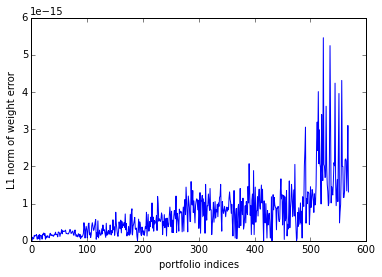

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
diffs = np.mean(np.abs(weights_pymcef - weights_cylp), axis=1)
plt.plot(diffs)
plt.xlabel('portfolio indices')
plt.ylabel('L1 norm of weight error')